In [1]:
import os
import warnings
from IPython.display import display, HTML
import platform
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis, wilcoxon
from scipy.signal import butter, welch, filtfilt, resample
from scipy import stats
# import xgboost as xgb
# from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import svm
import time
import random
from PreprocessFcns import *
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

sns.set_context('talk',font_scale=1)
#-- For interactive plots--
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

from sklearn.model_selection import LeaveOneGroupOut
from sklearn import preprocessing
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

In [2]:
# get all data and remove useless rows
summary_info = pd.read_csv('//FS2.smpp.local//RTO//CIS-PD Study\\subj visit summary info.csv', index_col = 0)
Xtrain = pd.read_csv('//FS2.smpp.local/RTO/CIS-PD Study/Clinic WACC features/FeaturesHP_All_subjs.csv',index_col=0)
Xtrain = Xtrain[Xtrain.Subject!=1020]
Xtrain = Xtrain[~Xtrain['Tremor'].isnull()]
Xtrain = Xtrain[~Xtrain['Bradykinesia'].isnull()]

Xtrain = Xtrain.reset_index(drop= True)
for index, row in Xtrain.iterrows():
    if (row['Visit'] == '4 Weeks'):
        #print(row['Visit'])
        #print(Xtrain.loc[index, 'Visit'])
        #print(index)
        Xtrain.loc[index, 'Visit'] = '1 Month'
counter = 0
subjects = Xtrain['Subject'].unique()
features = pd.DataFrame()
for s in subjects:
    strain = Xtrain[Xtrain['Subject'] == s]
    visits = strain['Visit'].unique()
    # print(s.__str__() + ' visits: ' + visits)
    for v in visits:
        vtrain = strain[strain['Visit'] == v]
        mds = float('Nan')
        baseline_mds = float('Nan')
        
        try: 
            mds = int(summary_info.loc[(summary_info.VisitNm == v) & (summary_info["SubjectCode"] == s), 'MDS_score'])
        except:
            mds = float('Nan')
        try:
            baseline_mds = int(summary_info.loc[(summary_info.VisitNm == 'Baseline') & (summary_info["SubjectCode"] == s), 'MDS_score'])
        except:
            baseline_mds = float('Nan')
        if (np.isnan(mds) or np.isnan(baseline_mds)):
            #print(v + s.__str__())
            #counter += 1
            #display(vtrain)
            continue
        #display(vtrain)
        
        vtrain = vtrain.iloc[:, 5:-2]
        columns = vtrain.columns.values.tolist()

        for i in range(100):
        
            cols = ['Subject', 'MDS score', 'Visit', 'baseline MDS']
            vals = [s, mds, v, baseline_mds]
            for c in columns:
                cols.append(c + " mean")
                cols.append(c + " var")
                sample = vtrain[c].sample(frac = 0.1, replace = False)
                vals.append(sample.mean())
                vals.append(sample.var())
            
            df = pd.DataFrame(data = [vals], columns = cols)
            features = features.append(df, ignore_index = True)
        
for index, row in features.iterrows():
    if (row['Visit'] == '1 Month'):
        features.loc[index, 'Visit'] = 2
    elif (row['Visit'] == '2 Weeks: Time 0'):
        features.loc[index, 'Visit'] = 0
    elif (row['Visit'] == '2 Weeks: Time 60'):
        features.loc[index, 'Visit'] = 1
features

,Subject,MDS score,Visit,baseline MDS,RMSX mean,RMSX var,RMSY mean,RMSY var,RMSZ mean,RMSZ var,...,PSD_std mean,PSD_std var,PSD_skew mean,PSD_skew var,PSD_kur mean,PSD_kur var,jerk_mean mean,jerk_mean var,jerk_std mean,jerk_std var
0,1016,19,0,20,0.004070,0.000010,0.004074,0.000021,0.004304,0.000012,...,0.001547,1.095675e-05,3.567439,0.922384,14.378771,98.088167,-0.000082,5.503874e-07,0.066814,0.003237
1,1016,19,0,20,0.004591,0.000008,0.005317,0.000020,0.004546,0.000013,...,0.001698,5.435721e-06,3.617838,0.864856,14.324016,119.465267,0.000418,3.015400e-07,0.053158,0.001294
2,1016,19,0,20,0.003793,0.000006,0.007054,0.000060,0.004088,0.000014,...,0.001892,1.793282e-05,3.472184,1.014496,12.294800,64.499839,-0.000010,1.212193e-07,0.031935,0.001147
3,1016,19,0,20,0.004790,0.000013,0.005171,0.000025,0.008213,0.000094,...,0.000985,2.236664e-06,3.807975,1.695234,13.601143,71.264172,0.000128,2.794783e-07,0.038470,0.000826
4,1016,19,0,20,0.003107,0.000008,0.006829,0.000061,0.005984,0.000054,...,0.001831,8.111981e-06,3.474407,1.303575,14.657603,131.086876,0.000049,2.544367e-07,0.062333,0.002845
5,1016,19,0,20,0.005957,0.000006,0.003324,0.000007,0.006574,0.000098,...,0.001491,5.987654e-06,3.494607,0.771848,18.548324,136.528523,-0.000226,2.322416e-06,0.048185,0.001243
6,1016,19,0,20,0.004185,0.000008,0.006269,0.000057,0.002927,0.000006,...,0.002275,1.895217e-05,3.957752,1.154447,15.013249,105.629731,0.000187,3.145662e-07,0.066998,0.002591
7,1016,19,0,20,0.004707,0.000009,0.004700,0.000017,0.004481,0.000015,...,0.001220,3.411603e-06,3.291374,1.380303,14.045813,43.630472,-0.000027,2.490336e-08,0.057318,0.001579
8,1016,19,0,20,0.004933,0.000011,0.002875,0.000013,0.005076,0.000014,...,0.001664,1.091941e-05,3.437194,1.430357,16.517069,65.167159,0.000084,2.035532e-07,0.050587,0.002328
9,1016,19,0,20,0.003942,0.000009,0.006708,0.000065,0.006713,0.000060,...,0.000993,3.038990e-06,4.076566,2.119090,13.958325,125.681504,0.000603,1.671069e-06,0.065070,0.002353


In [3]:
### calculate first stack ###
a = []
b = []
v = []
subjs = []
pred_RFR = []
pred_NN = []
pred_LN = []
pred_LARS = []
pred_KNR = []

subjects = features['Subject'].unique()

from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lars
from sklearn.neighbors import KNeighborsRegressor


for s in subjects:

    clf_MDS_RFR = RandomForestRegressor(n_estimators=50, random_state = 2)
    clf_MDS_NN = MLPRegressor(max_iter = 1000, random_state = 2)
    clf_MDS_LN = LinearRegression()
    clf_MDS_LARS = Lars(eps = 2.220446049250313e-7)
    clf_MDS_KNR = KNeighborsRegressor(weights = 'distance')
    
    Xtrain = features[(features['Subject'] != s) & (features['Visit'] == 1)]
    ytrain = Xtrain['MDS score']
    ytrain = ytrain.values
    ytrain = ytrain.astype(int)
    Xtrain = Xtrain.iloc[:, 4:].values
    

    scaler = StandardScaler() 
    scaler.fit(Xtrain)  
    Xtrain_std = scaler.transform(Xtrain)
    
    clf_MDS_RFR.fit(Xtrain, ytrain)
    clf_MDS_NN.fit(Xtrain_std, ytrain)
    clf_MDS_LN.fit(Xtrain_std, ytrain)
    clf_MDS_LARS.fit(Xtrain_std, ytrain)
    clf_MDS_KNR.fit(Xtrain_std, ytrain)
    
    Xtest = features[(features['Subject'] == s) & (features['Visit'] == 1)]
    
    actual = Xtest['MDS score'].values.astype(int)
    bmds = Xtest['baseline MDS'].values.astype(int)
    vis = Xtest['Visit'].values.astype(int)

    Xtest = Xtest.iloc[:, 4:].values
    

    if (len(Xtest) != 0):
        Xtest_std = scaler.transform(Xtest)
        a += list(actual)
        b += list(bmds)
        v += list(vis)
        subjs += [s for elem in list(actual)]
        pred_RFR += list(clf_MDS_RFR.predict(Xtest))
        pred_NN += list(clf_MDS_NN.predict(Xtest_std))
        pred_LN += list(clf_MDS_LN.predict(Xtest_std))
        pred_LARS += list(clf_MDS_LARS.predict(Xtest_std))
        pred_KNR += list(clf_MDS_KNR.predict(Xtest_std))

stacked_predictions = pd.DataFrame()
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'subj', value = subjs)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'actual mds', value = a)
# stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'visit', value = v)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'baseline mds', value = b)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred RFR', value = pred_RFR)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred NN', value = pred_NN)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred LN', value = pred_LN)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred LARS', value = pred_LARS)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred KNR', value = pred_KNR)

stacked_predictions.style
stacked_predictions.corr()

,subj,actual mds,baseline mds,pred RFR,pred NN,pred LN,pred LARS,pred KNR
subj,1.000000,0.000215,0.337356,0.509282,0.358307,0.547143,0.542799,0.344331
actual mds,0.000215,1.000000,0.655813,0.224293,0.455916,-0.094042,-0.047992,0.145898
baseline mds,0.337356,0.655813,1.000000,0.320170,0.321435,0.250292,0.260553,0.169707
pred RFR,0.509282,0.224293,0.320170,1.000000,0.503420,0.608913,0.614988,0.487708
pred NN,0.358307,0.455916,0.321435,0.503420,1.000000,0.446048,0.465813,0.486433
pred LN,0.547143,-0.094042,0.250292,0.608913,0.446048,1.000000,0.990069,0.338253
pred LARS,0.542799,-0.047992,0.260553,0.614988,0.465813,0.990069,1.000000,0.353976
pred KNR,0.344331,0.145898,0.169707,0.487708,0.486433,0.338253,0.353976,1.000000


In [4]:
### calculate second stack from first stack ###
second_stack_predictions_RFR = []
second_stack_predictions_NN = []
second_stack_predictions_LN = []
second_stack_predictions_LARS = []
second_stack_predictions_KNR = []
actual_mds = []
baseline_mds = []
subjs2 = []

clf_stacked_RFR = RandomForestRegressor(n_estimators=50, random_state = 2)
clf_stacked_NN = MLPRegressor(max_iter = 10000, random_state = 2)
clf_stacked_LN = LinearRegression()
clf_stacked_LARS = Lars(eps = 2.220446049250313e-7)
clf_stacked_KNR = KNeighborsRegressor(weights = 'distance')

for s in stacked_predictions['subj'].unique():
    stacked_train = stacked_predictions[stacked_predictions.subj != s]
    stacked_test = stacked_predictions[stacked_predictions.subj == s]
    stacked_ytrain = stacked_train['actual mds'].values.astype(int)
    stacked_ytest = stacked_test['actual mds'].values.astype(int)
    bmds = stacked_test['baseline mds'].values.astype(int)
    stacked_train = stacked_train.iloc[:, 2:].values
    stacked_test = stacked_test.iloc[:, 2:].values
    
    scaler = StandardScaler() 
    scaler.fit(stacked_train)  
    stacked_train_std = scaler.transform(stacked_train)
    stacked_test_std = scaler.transform(stacked_test)
    
    clf_stacked_RFR.fit(stacked_train, stacked_ytrain)
    clf_stacked_NN.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_LN.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_LARS.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_KNR.fit(stacked_train_std, stacked_ytrain)
    
    if (len(stacked_test) != 0):
        actual_mds += list(stacked_ytest)
        baseline_mds += list(bmds)
        second_stack_predictions_RFR += list(clf_stacked_RFR.predict(stacked_test))
        second_stack_predictions_NN += list(clf_stacked_NN.predict(stacked_test_std))
        second_stack_predictions_LN += list(clf_stacked_LN.predict(stacked_test_std))
        second_stack_predictions_LARS += list(clf_stacked_LARS.predict(stacked_test_std))
        second_stack_predictions_KNR += list(clf_stacked_KNR.predict(stacked_test_std))
        
        subjs2 += [s for elem in list(stacked_ytest)]

second_stack_predictions = pd.DataFrame()
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'subj', value = np.array(subjs2))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'actual mds', value = np.array(actual_mds))
#second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'baseline mds', value = np.array(baseline_mds))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred RFR', value = second_stack_predictions_RFR)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred NN', value = second_stack_predictions_NN)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred LN', value = second_stack_predictions_LN)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred LARS', value = second_stack_predictions_LARS)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred KNR', value = second_stack_predictions_KNR)
second_stack_predictions.corr()

,subj,actual mds,pred RFR,pred NN,pred LN,pred LARS,pred KNR
subj,1.000000,0.000215,0.223975,0.179380,0.231870,0.231870,0.266588
actual mds,0.000215,1.000000,0.198601,0.423028,0.680473,0.680473,0.405364
pred RFR,0.223975,0.198601,1.000000,0.582314,0.472967,0.472967,0.554942
pred NN,0.179380,0.423028,0.582314,1.000000,0.683447,0.683447,0.879676
pred LN,0.231870,0.680473,0.472967,0.683447,1.000000,1.000000,0.597898
pred LARS,0.231870,0.680473,0.472967,0.683447,1.000000,1.000000,0.597898
pred KNR,0.266588,0.405364,0.554942,0.879676,0.597898,0.597898,1.000000


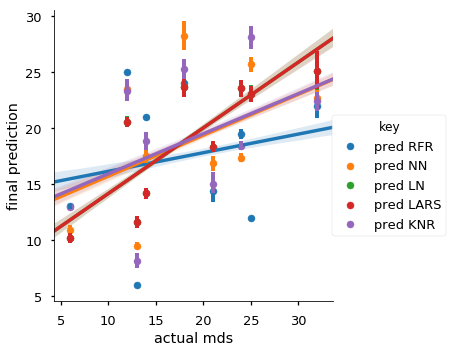

In [5]:
### calculate final predictions without second stack (from first stack only) ###
one_stack_predictions = pd.DataFrame()
for col in list(second_stack_predictions.columns.values)[2:]:
    df = pd.DataFrame()
    df['subj'] = second_stack_predictions['subj']
    df['actual mds'] = second_stack_predictions['actual mds']
    df['final prediction'] = second_stack_predictions[col]
    df['key'] = col
    one_stack_predictions = one_stack_predictions.append(df, ignore_index = True)

sns.lmplot(x = 'actual mds', y = 'final prediction', hue = 'key', data = one_stack_predictions, order = 1, x_estimator=np.mean)

correlation coefficient: 0.19860070751163386
RMSE: 8.670733786710327


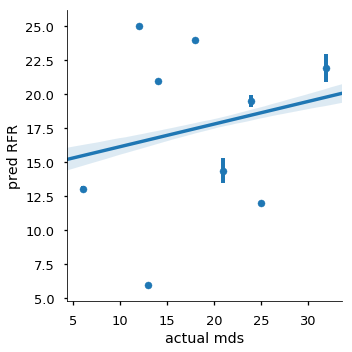

In [6]:
### 1 stack followed by RFR ###
print('correlation coefficient: ' + np.corrcoef(second_stack_predictions['actual mds'], second_stack_predictions['pred RFR'])[0][1].__str__())
print('RMSE: ' + float(np.sqrt(np.mean((np.array(second_stack_predictions['actual mds'].values) - np.array(second_stack_predictions['pred RFR'].values))**2))).__str__()) 
sns.lmplot(x = 'actual mds', y = 'pred RFR', data = second_stack_predictions, order = 1, x_estimator=np.mean)

correlation coefficient: 0.4230275111418436
RMSE: 7.386454119030863


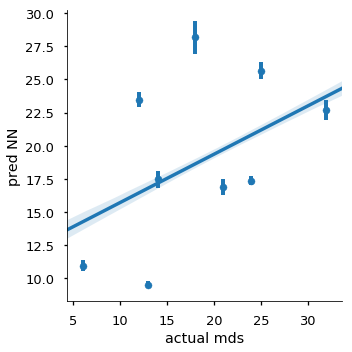

In [7]:
### 1 stack followed by NN ###
print('correlation coefficient: ' + np.corrcoef(second_stack_predictions['actual mds'], second_stack_predictions['pred NN'])[0][1].__str__())
print('RMSE: ' + float(np.sqrt(np.mean((np.array(second_stack_predictions['actual mds'].values) - np.array(second_stack_predictions['pred NN'].values))**2))).__str__()) 
sns.lmplot(x = 'actual mds', y = 'pred NN', data = second_stack_predictions, order = 1, x_estimator=np.mean)

correlation coefficient: 0.6804728452335229
RMSE: 5.557093006054381


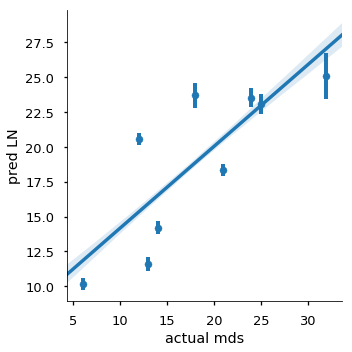

In [8]:
### 1 stack followed by LN ###
print('correlation coefficient: ' + np.corrcoef(second_stack_predictions['actual mds'], second_stack_predictions['pred LN'])[0][1].__str__())
print('RMSE: ' + float(np.sqrt(np.mean((np.array(second_stack_predictions['actual mds'].values) - np.array(second_stack_predictions['pred LN'].values))**2))).__str__()) 
sns.lmplot(x = 'actual mds', y = 'pred LN', data = second_stack_predictions, order = 1, x_estimator=np.mean)

correlation coefficient: 0.68047284523352
RMSE: 5.5570930060544645


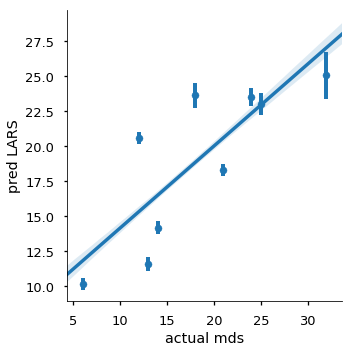

In [9]:
### 1 stack followed by LARS ###
print('correlation coefficient: ' + np.corrcoef(second_stack_predictions['actual mds'], second_stack_predictions['pred LARS'])[0][1].__str__())
print('RMSE: ' + float(np.sqrt(np.mean((np.array(second_stack_predictions['actual mds'].values) - np.array(second_stack_predictions['pred LARS'].values))**2))).__str__()) 
sns.lmplot(x = 'actual mds', y = 'pred LARS', data = second_stack_predictions, order = 1, x_estimator=np.mean)

correlation coefficient: 0.40536438231408495
RMSE: 7.565144495282399


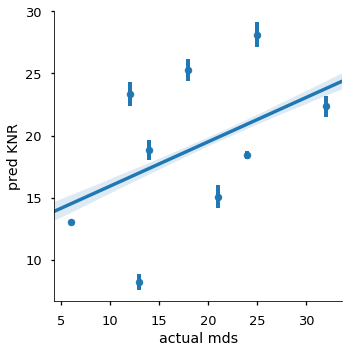

In [10]:
### 1 stack followed by KNR ###
print('correlation coefficient: ' + np.corrcoef(second_stack_predictions['actual mds'], second_stack_predictions['pred KNR'])[0][1].__str__())
print('RMSE: ' + float(np.sqrt(np.mean((np.array(second_stack_predictions['actual mds'].values) - np.array(second_stack_predictions['pred KNR'].values))**2))).__str__()) 
sns.lmplot(x = 'actual mds', y = 'pred KNR', data = second_stack_predictions, order = 1, x_estimator=np.mean)

In [11]:
### calculate second stack from first stack - WITHOUT BASELINE ###
second_stack_predictions_RFR = []
second_stack_predictions_NN = []
second_stack_predictions_LN = []
second_stack_predictions_LARS = []
second_stack_predictions_KNR = []
actual_mds = []
baseline_mds = []
subjs2 = []

clf_stacked_RFR = RandomForestRegressor(n_estimators=50, random_state = 2)
clf_stacked_NN = MLPRegressor(max_iter = 10000, random_state = 2)
clf_stacked_LN = LinearRegression()
clf_stacked_LARS = Lars(eps = 2.220446049250313e-7)
clf_stacked_KNR = KNeighborsRegressor(weights = 'distance')

for s in stacked_predictions['subj'].unique():
    stacked_train = stacked_predictions[stacked_predictions.subj != s]
    stacked_test = stacked_predictions[stacked_predictions.subj == s]
    stacked_ytrain = stacked_train['actual mds'].values.astype(int)
    stacked_ytest = stacked_test['actual mds'].values.astype(int)
    bmds = stacked_test['baseline mds'].values.astype(int)
    stacked_train = stacked_train.iloc[:, 3:].values
    stacked_test = stacked_test.iloc[:, 3:].values
    
    scaler = StandardScaler() 
    scaler.fit(stacked_train)  
    stacked_train_std = scaler.transform(stacked_train)
    stacked_test_std = scaler.transform(stacked_test)
    
    clf_stacked_RFR.fit(stacked_train, stacked_ytrain)
    clf_stacked_NN.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_LN.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_LARS.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_KNR.fit(stacked_train_std, stacked_ytrain)
    
    if (len(stacked_test) != 0):
        actual_mds += list(stacked_ytest)
        baseline_mds += list(bmds)
        second_stack_predictions_RFR += list(clf_stacked_RFR.predict(stacked_test))
        second_stack_predictions_NN += list(clf_stacked_NN.predict(stacked_test_std))
        second_stack_predictions_LN += list(clf_stacked_LN.predict(stacked_test_std))
        second_stack_predictions_LARS += list(clf_stacked_LARS.predict(stacked_test_std))
        second_stack_predictions_KNR += list(clf_stacked_KNR.predict(stacked_test_std))
        
        subjs2 += [s for elem in list(stacked_ytest)]

second_stack_predictions = pd.DataFrame()
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'subj', value = np.array(subjs2))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'actual mds', value = np.array(actual_mds))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'baseline mds', value = np.array(baseline_mds))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred RFR', value = second_stack_predictions_RFR)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred NN', value = second_stack_predictions_NN)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred LN', value = second_stack_predictions_LN)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred LARS', value = second_stack_predictions_LARS)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred KNR', value = second_stack_predictions_KNR)
second_stack_predictions.corr()

,subj,actual mds,baseline mds,pred RFR,pred NN,pred LN,pred LARS,pred KNR
subj,1.000000,0.000215,0.337356,0.039229,-0.146219,-0.077663,-0.077663,0.032490
actual mds,0.000215,1.000000,0.655813,0.242562,0.229739,0.350830,0.350830,0.249544
baseline mds,0.337356,0.655813,1.000000,0.038899,-0.113197,-0.062744,-0.062744,-0.010308
pred RFR,0.039229,0.242562,0.038899,1.000000,0.748744,0.429966,0.429966,0.828432
pred NN,-0.146219,0.229739,-0.113197,0.748744,1.000000,0.692112,0.692112,0.793349
pred LN,-0.077663,0.350830,-0.062744,0.429966,0.692112,1.000000,1.000000,0.438567
pred LARS,-0.077663,0.350830,-0.062744,0.429966,0.692112,1.000000,1.000000,0.438567
pred KNR,0.032490,0.249544,-0.010308,0.828432,0.793349,0.438567,0.438567,1.000000


In [24]:
### calculate final predictions from second stack ###
actual_mds = []
predictions_final = []
subjs3 = []

#clf_final = RandomForestRegressor(n_estimators=50, random_state = 2) # could change???
#clf_final = MLPRegressor(max_iter = 10000, random_state = 2)
#clf_final = LinearRegression()
clf_final = Lars(eps = 2.220446049250313e-7)
#clf_final = KNeighborsRegressor(weights = 'distance')

for s in second_stack_predictions['subj'].unique():
    second_stack_train = second_stack_predictions[second_stack_predictions.subj != s]
    second_stack_test = second_stack_predictions[second_stack_predictions.subj == s]
    second_stack_ytrain = second_stack_train['actual mds'].values.astype(int)
    second_stack_ytest = second_stack_test['actual mds'].values.astype(int)
    second_stack_train = second_stack_train.iloc[:, 2:].values
    second_stack_test = second_stack_test.iloc[:, 2:].values
    
    scaler = StandardScaler() 
    scaler.fit(second_stack_train)  
    second_stack_std = scaler.transform(second_stack_train)
    second_stack_test_std = scaler.transform(second_stack_test)
    
    clf_final.fit(second_stack_train, second_stack_ytrain)
    
    if (len(second_stack_test) != 0):
        actual_mds += list(second_stack_ytest)
        predictions_final += list(clf_final.predict(second_stack_test))
        subjs3 += [s for elem in list(second_stack_ytest)]

predictions = pd.DataFrame()
predictions.insert(loc = len(predictions.columns.values), column = 'subj', value = np.array(subjs3))
predictions.insert(loc = len(predictions.columns.values), column = 'actual mds', value = np.array(actual_mds))
predictions.insert(loc = len(predictions.columns.values), column = 'final prediction', value = np.array(predictions_final))
predictions.corr()

,subj,actual mds,final prediction
subj,1.000000,0.000215,0.426875
actual mds,0.000215,1.000000,0.616104
final prediction,0.426875,0.616104,1.000000


correlation coefficient: 0.6161037191032847
RMSE: 5.82277730726383


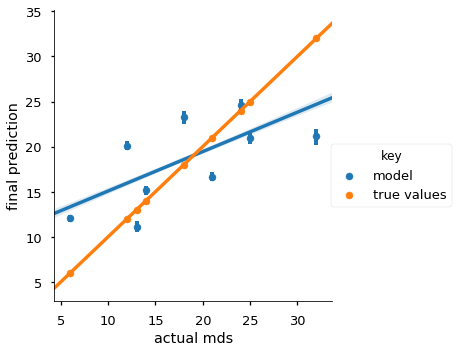

In [25]:
predictions['key'] = 'model'
actual_for_comp = pd.DataFrame()
actual_for_comp['subj'] = predictions['subj']
actual_for_comp['actual mds'] = predictions['actual mds']
actual_for_comp['final prediction'] = predictions['actual mds']
actual_for_comp['key'] = 'true values'

#print('excluding datapoints with the highest and lowest actual MDS scores')
#predictions = predictions[(predictions['actual mds'] > 10) & (predictions['actual mds'] < 30)]

print('correlation coefficient: ' + np.corrcoef(predictions['final prediction'], predictions['actual mds'])[0][1].__str__())
print('RMSE: ' + float(np.sqrt(np.mean((np.array(predictions['final prediction']) - predictions['actual mds'])**2))).__str__()) 

df_display = predictions.append(actual_for_comp, ignore_index = True)
sns.lmplot(x = 'actual mds', y = 'final prediction', hue = 'key', data = df_display, order = 1, x_estimator=np.mean)